<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [2]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd #pandas to create small dataframes 
import numpy as np #Do aritmetic operations on arrays

import matplotlib
import matplotlib.pylab as plt
import seaborn as sns #Plots
from matplotlib import rcParams #Size of plots  
import math
import pickle
import os

import xgboost as xgb
import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [95]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [96]:
def preferential_attachment(a,b):
    pro=a*b
    return pro

In [97]:
def svd_dot(svd_u_1, svd_u_2, svd_u_3, svd_u_4,svd_u_5, svd_u_6,
            svd_v_1, svd_v_2,svd_v_3, svd_v_4, svd_v_5, svd_v_6):
    
    u=np.array([svd_u_1, svd_u_2, svd_u_3, svd_u_4,svd_u_5, svd_u_6])
    v=np.array([svd_v_1, svd_v_2,svd_v_3, svd_v_4, svd_v_5, svd_v_6])
    dot=u.dot(v)
    
    return dot
    

In [98]:
df_final_train['svd_dot_s']= df_final_train.apply(lambda row: svd_dot(row['svd_u_s_1'], row['svd_u_s_2'],row['svd_u_s_3'], row['svd_u_s_4'], row['svd_u_s_5'], row['svd_u_s_6'],row['svd_v_s_1'], row['svd_v_s_2'],
       row['svd_v_s_3'], row['svd_v_s_4'], row['svd_v_s_5'], row['svd_v_s_6']),axis=1)

df_final_test['svd_dot_s']= df_final_test.apply(lambda row: svd_dot(row['svd_u_s_1'], row['svd_u_s_2'],row['svd_u_s_3'], row['svd_u_s_4'], row['svd_u_s_5'], row['svd_u_s_6'],row['svd_v_s_1'], row['svd_v_s_2'],
       row['svd_v_s_3'], row['svd_v_s_4'], row['svd_v_s_5'], row['svd_v_s_6']),axis=1)

In [99]:
df_final_train['svd_dot_d']= df_final_train.apply(lambda row: svd_dot(row['svd_u_d_1'], row['svd_u_d_2'],row['svd_u_d_3'], row['svd_u_d_4'], row['svd_u_d_5'], row['svd_u_d_6'],row['svd_v_d_1'], row['svd_v_d_2'],
       row['svd_v_d_3'], row['svd_v_d_4'], row['svd_v_d_5'], row['svd_v_d_6']),axis=1)

df_final_test['svd_dot_d']= df_final_test.apply(lambda row: svd_dot(row['svd_u_d_1'], row['svd_u_d_2'],row['svd_u_d_3'], row['svd_u_d_4'], row['svd_u_d_5'], row['svd_u_d_6'],row['svd_v_d_1'], row['svd_v_d_2'],
       row['svd_v_d_3'], row['svd_v_d_4'], row['svd_v_d_5'], row['svd_v_d_6']),axis=1)

In [100]:
df_final_train['preferential_attachment']= df_final_train.apply(lambda row: preferential_attachment(row['num_followees_s'],row['num_followees_d']),axis=1)
df_final_test['preferential_attachment']= df_final_test.apply(lambda row: preferential_attachment(row['num_followees_s'],row['num_followees_d']),axis=1)

In [101]:
df_final_train.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot_s,svd_dot_d,preferential_attachment
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,2.069078e-11,1.206402e-12,120.0
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,4.985937e-04,5.807276e-03,8662.0


In [102]:
#d=df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']]==[0,0,0,0,0,0]

In [103]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'svd_dot_s', 'svd_dot_d', 'preferential_attachment'],
      dtype='object')

## Removing outliers

#### I tried by removing outliers on train data, but the result didnt improve, so I removed it

#### Possible outliers in 'num_followers_s'

In [118]:
up=np.percentile(df_final_train['num_followers_s'],[99])[0]
print(up*3)
print(np.percentile(df_final_train['num_followers_s'],[100])[0])

327.0
454.0


In [119]:
df_final_train[df_final_train['num_followers_s']>3*up]

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot_s,svd_dot_d,preferential_attachment
447,0,0.000000,0.000636,0.000000,335,23,125,1,0,0.000000,...,2.464429e-10,-4.286468e-09,1.054203e-10,2.622905e-04,1.255325e-10,3.507100e-09,1.182410e-11,2.805197e-09,1.637353e-08,2875.0
9745,0,0.004202,0.000000,0.013218,333,27,212,0,1,0.509220,...,1.668640e-12,-3.582752e-10,-1.083343e-09,1.122730e-01,4.812469e-10,1.794929e-09,3.146870e-10,5.800504e-07,5.745454e-03,5724.0
12536,0,0.000000,0.006272,0.000000,398,124,23,9,0,0.000000,...,3.304133e-15,1.059943e-10,1.451881e-01,1.346051e-09,2.717789e-10,8.400402e-07,1.112728e-13,7.278677e-04,3.678897e-05,2852.0
16527,0,0.209677,0.020517,0.361111,454,48,27,111,13,6.640247,...,7.683233e-16,5.308969e-11,6.913136e-02,3.014266e-09,1.281213e-10,2.290941e-05,3.169470e-14,8.083847e-06,1.431477e-04,1296.0
17877,0,0.084746,0.027026,0.163627,411,83,45,164,10,4.285593,...,3.312963e-14,1.132448e-10,1.545731e-01,1.633750e-09,2.874073e-10,9.835897e-07,8.983889e-14,2.988044e-03,1.499946e-03,3735.0
18772,0,0.000000,0.011342,0.000000,416,117,33,32,0,0.000000,...,1.247092e-14,1.106756e-10,1.515156e-01,1.604655e-09,2.820145e-10,9.337405e-07,8.885774e-14,2.570528e-03,3.408985e-04,3861.0
19201,0,0.000000,0.014998,0.000000,398,82,23,47,0,0.000000,...,5.598810e-15,1.059943e-10,1.451881e-01,1.346051e-09,2.717789e-10,8.400402e-07,1.112728e-13,8.877927e-04,3.678897e-05,1886.0
19992,0,0.006897,0.001954,0.019518,335,21,125,3,1,0.521084,...,4.258056e-12,-4.286468e-09,1.054203e-10,2.622905e-04,1.255325e-10,3.507100e-09,1.182410e-11,4.045134e-10,1.637353e-08,2625.0
20512,0,0.000000,0.000000,0.000000,454,65,27,0,0,0.000000,...,2.065508e-16,5.308969e-11,6.913136e-02,3.014266e-09,1.281213e-10,2.290941e-05,3.169470e-14,8.068937e-06,1.431477e-04,1755.0
21368,0,0.000000,0.011566,0.000000,398,92,23,28,0,0.000000,...,8.201960e-15,1.059943e-10,1.451881e-01,1.346051e-09,2.717789e-10,8.400402e-07,1.112728e-13,1.218818e-03,3.678897e-05,2116.0


In [120]:
# df_final_train.num_followers_s[df_final_train.num_followers_s>3*up]=3*up

#### Possible outliers in 'num_followees_s'

In [77]:
up=np.percentile(df_final_train['num_followees_s'],[99])[0]
print(up*3)
print(np.percentile(df_final_train['num_followees_s'],[100])[0])

393.0
1261.0


In [78]:
df_final_train[df_final_train['num_followees_s']>3*up]

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot_s,svd_dot_d,preferential_attachment
90,1492489,539446,1,0,0.003130,0.000000,0.024581,32,1261,21,...,4.542810e-13,-7.525616e-11,2.908501e-11,0.000045,3.814052e-11,9.936429e-11,2.968398e-12,4.254119e-07,4.520492e-10,26481.0
3906,735020,1665976,1,0,0.000000,0.000000,0.000000,5,525,5,...,6.331962e-11,2.307755e-12,-1.810891e-12,0.000428,3.527699e-12,8.155974e-12,9.031160e-13,5.045791e-03,3.568068e-09,2625.0
11474,141489,1701177,1,0,0.003333,0.000000,0.022856,17,589,13,...,2.400101e-13,-2.616920e-11,4.802798e-12,0.000048,3.118608e-11,1.478092e-11,6.400803e-13,1.349185e-08,1.186830e-10,7657.0
14202,1855498,1375307,1,0,0.005871,0.000000,0.021543,61,473,41,...,2.472968e-10,-4.288707e-11,1.267803e-11,0.000096,1.090874e-11,1.316054e-09,1.623382e-12,1.367889e-05,1.592443e-09,19393.0
14703,735020,864352,1,0,0.045802,0.019087,0.103510,93,525,160,...,6.331962e-11,2.251156e-10,-1.436247e-10,0.017889,8.697761e-11,2.025645e-10,1.839519e-11,5.045791e-03,6.856252e-04,84000.0
15424,4850,725549,1,0,0.005391,0.000000,0.024697,20,709,37,...,1.456664e-12,-3.166100e-11,7.093549e-10,0.000122,7.688231e-12,1.898026e-11,2.516106e-10,3.302825e-06,1.279796e-08,26233.0
15904,1855498,1822263,1,0,0.002045,0.000000,0.011152,21,473,17,...,2.472968e-10,-2.840338e-11,7.951704e-12,0.000083,6.107133e-12,3.063714e-10,1.225973e-12,1.367889e-05,1.722643e-09,8041.0
24184,141489,640805,1,0,0.000000,0.000000,0.000000,48,589,39,...,2.400101e-13,-2.164720e-11,4.141884e-12,0.001379,1.262413e-11,2.852952e-10,1.065177e-11,1.349185e-08,2.370259e-06,22971.0
25722,1855498,1449452,1,0,0.000000,0.000000,0.000000,16,473,9,...,2.472968e-10,-1.731327e-11,5.862919e-12,0.000082,4.067609e-12,1.347008e-11,9.385706e-13,1.367889e-05,6.994203e-11,4257.0
28008,4850,1187866,1,0,0.010363,0.004623,0.035656,60,709,71,...,1.456664e-12,-9.267351e-11,3.879272e-11,0.000666,4.672572e-11,1.197084e-10,7.450901e-10,3.302825e-06,1.161356e-07,50339.0


In [121]:
# df_final_train.num_followees_s[df_final_train.num_followees_s>3*up]=3*up

#### Possible outliers in 'num_followees_d'

In [122]:
up=np.percentile(df_final_train['num_followees_d'],[99])[0]
print(up*3)
print(np.percentile(df_final_train['num_followees_d'],[100])[0])

291.0
525.0


In [123]:
df_final_train[df_final_train['num_followees_d']>3*up]

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot_s,svd_dot_d,preferential_attachment
12023,0,0.001972,0.000000,0.007772,66,35,473,0,1,0.480126,...,1.125347e-12,-1.000437e-09,2.627030e-11,2.084403e-03,1.849090e-11,2.846222e-10,2.472968e-10,8.514610e-09,1.367889e-05,16555.0
29574,0,0.000000,0.000000,0.000000,305,11,525,0,0,0.000000,...,7.917967e-14,1.690237e-09,-1.178616e-09,1.146173e-01,4.998348e-10,3.418188e-09,6.331962e-11,1.147415e-08,5.045791e-03,5775.0
36928,0,0.016181,0.017747,0.062383,63,22,292,5,5,4.145142,...,9.396476e-13,-1.753970e-11,8.438901e-11,1.756609e-04,6.311059e-12,1.061156e-11,1.785101e-12,9.442199e-10,2.695546e-07,6424.0
44569,0,0.000000,0.000000,0.000000,15,3,303,0,0,0.000000,...,1.621562e-14,-2.669654e-12,2.896446e-13,1.173982e-07,8.463012e-13,2.604753e-10,2.779809e-11,9.313332e-17,9.875681e-13,909.0
48960,0,0.000000,0.000000,0.000000,83,60,296,0,0,0.000000,...,1.152107e-12,-1.892458e-09,4.961899e-11,1.019406e-03,2.020406e-11,3.601846e-11,2.484625e-10,2.342807e-09,4.480250e-06,17760.0


In [124]:
# df_final_train.num_followees_d[df_final_train.num_followees_d>3*up]=3*up

### Train Test Split

In [104]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [105]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9127397996270662 test Score 0.8735130415802684
Estimators =  50 Train Score 0.920388349514563 test Score 0.9047941437819998
Estimators =  100 Train Score 0.9206611224873585 test Score 0.909175299056942
Estimators =  250 Train Score 0.921989966555184 test Score 0.9167331178914676
Estimators =  450 Train Score 0.9220733058732516 test Score 0.9167191369684758


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

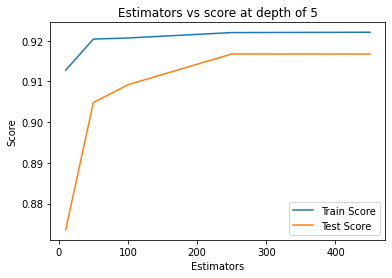

In [106]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.legend()
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8717293649272956 test Score 0.8568654526624664
depth =  9 Train Score 0.9573361932485573 test Score 0.9232978543672917
depth =  11 Train Score 0.9614766275259977 test Score 0.9249752167218578
depth =  15 Train Score 0.9639823413000457 test Score 0.9263414942214176
depth =  20 Train Score 0.9636347018979822 test Score 0.926282523965027
depth =  35 Train Score 0.9637401478833185 test Score 0.9262927219857557
depth =  50 Train Score 0.9637401478833185 test Score 0.9262927219857557
depth =  70 Train Score 0.9637401478833185 test Score 0.9262927219857557
depth =  130 Train Score 0.9637401478833185 test Score 0.9262927219857557


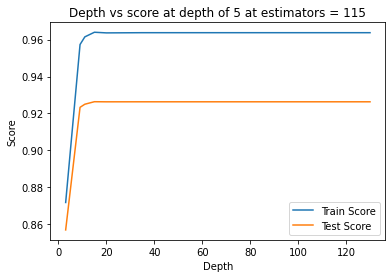

In [107]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.legend()
plt.show()

In [108]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',return_train_score=True,random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96207694 0.96165118 0.96025466 0.9619473  0.96289355]
mean train scores [0.96312216 0.9624725  0.96082216 0.96265367 0.96399468]


In [109]:
results=pd.DataFrame(rf_random.cv_results_)
results.sort_values(by='rank_test_score',inplace=True)
results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
4,9.838805,0.295069,0.118500,0.003807,14,28,111,121,"{'max_depth': 14, 'min_samples_leaf': 28, 'min...",0.963489,...,0.963755,0.963108,0.964663,0.964749,0.963923,0.964075,0.963804,0.963994,0.963995,0.000565
0,9.587391,0.986012,0.115465,0.003697,14,51,125,117,"{'max_depth': 14, 'min_samples_leaf': 51, 'min...",0.961668,...,0.962596,0.962778,0.963132,0.964305,0.962446,0.963468,0.963465,0.963393,0.963122,0.000556
3,8.388027,0.119853,0.117870,0.003637,13,49,165,108,"{'max_depth': 13, 'min_samples_leaf': 49, 'min...",0.962385,...,0.962219,0.962198,0.962661,0.963567,0.962437,0.962847,0.962027,0.962798,0.962654,0.000465


In [110]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [111]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [112]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [113]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9638262848781678
Test f1 score 0.9261062973035651


In [114]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


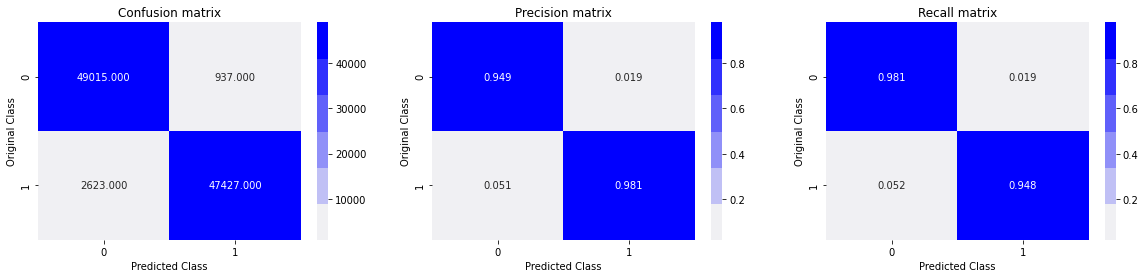

Test confusion_matrix


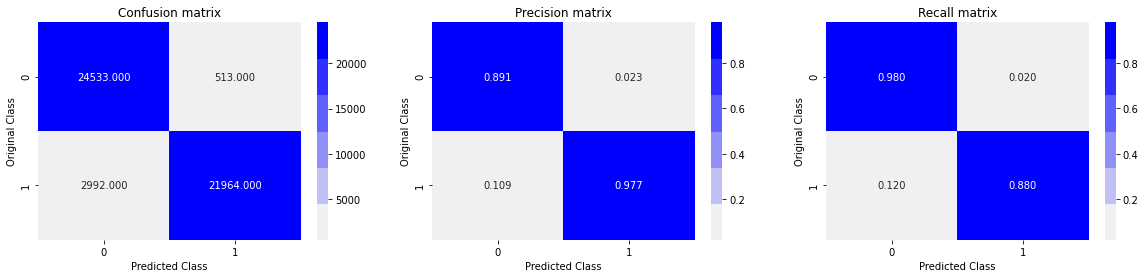

In [115]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

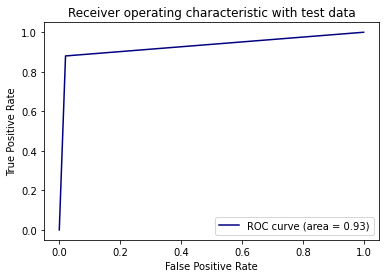

In [116]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

In [125]:
features

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'svd_dot_s', 'svd_dot_d', 'preferential_attachment'],
      dtype='object')

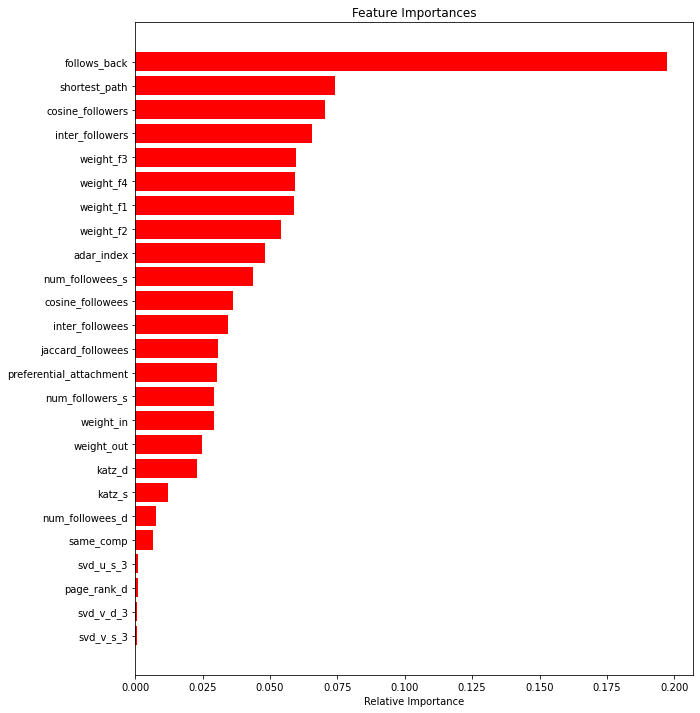

In [117]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()